# Assignment 2: Antonio Maschio


For this assignment, we started by replicate the magnetic characterization of the plate by probing and measuring the magnetic field. And after, the inverse problem was solved by obtaining a possible magnetic characterization of a plate based on probe measuring data.

importing libraries and data:

In [1]:
import numpy as np
from numpy import linalg
import sys
import matplotlib.pyplot as plt
from numpy import linalg

num_bands = 200

data = np.array([
 [-1.5000000e+001, -1.5167826e+002],
 [-1.4000000e+001, -1.8483299e+002],
 [-1.3000000e+001, -1.9652847e+002],
 [-1.2000000e+001, -1.9422822e+002],
 [-1.1000000e+001, -2.0008416e+002],
 [-1.0000000e+001, -1.0898694e+002],
 [-9.0000000e+000, -1.0283494e+002],
 [-8.0000000e+000, -1.1095155e+002],
 [-7.0000000e+000, -2.4268680e+001],
 [-6.0000000e+000,  1.5124974e+002],
 [-5.0000000e+000,  1.7372072e+002],
 [-4.0000000e+000,  1.8256831e+002],
 [-3.0000000e+000,  1.9576141e+002],
 [-2.0000000e+000,  1.5792854e+002],
 [-1.0000000e+000,  1.6639385e+002],
 [ 0.0000000e+000,  1.5012349e+002],
 [ 1.0000000e+000,  1.5690313e+002],
 [ 2.0000000e+000,  1.4514920e+002],
 [ 3.0000000e+000,  1.5850760e+002],
 [ 4.0000000e+000,  2.0629620e+002],
 [ 5.0000000e+000,  1.9522120e+002],
 [ 6.0000000e+000,  1.2467965e+002],
 [ 7.0000000e+000, -3.9320261e+001],
 [ 8.0000000e+000, -1.2332042e+002],
 [ 9.0000000e+000, -1.0644516e+002],
 [ 1.0000000e+001, -1.2705983e+002],
 [ 1.1000000e+001, -1.8128579e+002],
 [ 1.2000000e+001, -1.9004045e+002],
 [ 1.3000000e+001, -1.9321367e+002],
 [ 1.4000000e+001, -2.1211956e+002],
 [ 1.5000000e+001, -1.6349427e+002]
])

Visualization functions:

In [2]:
def grafia(lx,ly,n,caractheristics,datalabel,cor,plottitle,xlabel,ylabel,namepng): # generic function to use matplotlib
    fig = plt.figure(n,figsize=(15,9))
    # matplotlib.rc('font', **font)
    plt.title(plottitle,fontsize=28)
    plt.ylabel(ylabel, fontsize=26)
    plt.xlabel(xlabel, fontsize=26)
    # plt.yscale(yscale)
    plt.plot(lx, ly, caractheristics, label=datalabel,color=cor, markersize=12)
    plt.tick_params(axis='x', labelsize=24)
    plt.tick_params(axis='y', labelsize=24)
    # plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0),useMathText=True)
    plt.legend(loc='best', shadow=True, fontsize='x-large')
    plt.grid(linestyle=':')
    plt.savefig(namepng)

def visualize_plate(plate):
    plt.plot(plate[:, 1], label='Magnetic field')
    boundaries = np.where(plate[:, 0] == 1)[0]
    plt.vlines(boundaries, ymin=min(plate[:, 1]), ymax=max(plate[:, 1]),
               colors='g', linestyles=':', label='Stripe Boundaries')
    plt.xlabel('Band Index')
    plt.ylabel('Value')
    plt.legend()
    plt.savefig('ex.png')
    plt.show()

# Question 1

The likelihood function quantifies how well the parameters of a statistical model explain the observed data. Knowing that the data has a gaussian distribution profile we have the following expression:

$\rho (x) = cte \cdot \exp(-\dfrac{x - \mu}{2\sigma}) $

In this problem:

The measurement $x$ is the observed data $d_{obs}$ which is the initial 1D data vector with the magnetization value.

Then $\mu$ will be the model prediction Gm. 

And the variance $\sigma$ will be the covariance matrix. 

Since we have multiple measurements that are statistically independent, but each with the same Gaussian uncertainty (standard deviation of 25 nT), the C_d^{-1} will be a diagonal matrix with value 25.


$L(m) = cte \cdot \exp(- \frac{1}{2} (d_{obs}-Gm)^T C_d^{-1} (d_{obs}-Gm) ) $ 


# Question 2

The algorithm for this question was challenging. I began by initializing the plate array with the required distributions. For the plate array, I decided to use an approach involving an array of 2D arrays. The first value of each 2D array indicates if the plate location is a boundary, and the second value represents the magnetization.

In [3]:
def initialize_plate(num_bands, w0=8, sigma=0.25): # w0 is 4cm times 2
    """
    Initialize plate with physical stripes of exponentially distributed widths
    and Gaussian distributed magnetization.
    """
    r = np.zeros((num_bands, 2))
    current_pos = 0

    while current_pos < num_bands:
        width = int(np.random.exponential(w0))
        width = max(1, width)  # Ensure at least one band per stripe
        
        if current_pos + width > num_bands:
            width = num_bands - current_pos
        
        r[current_pos, 0] = 1
        magnetization = np.random.normal(0, sigma)
        r[current_pos:current_pos + width, 1] = magnetization
        
        current_pos += width
    
    # last position is marked as boundary
    r[-1, 0] = 1
    
    return r

30


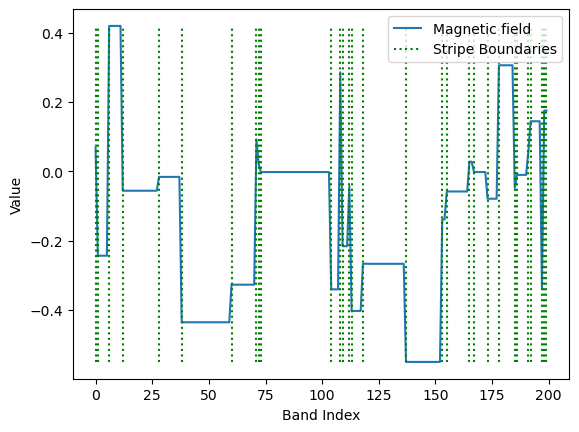

In [4]:
plate = initialize_plate(num_bands)
print(sum(1 for sublist in plate if sublist[0] == 1))
visualize_plate(plate)



Then created the function that will sample the $\rho(m)$ that solves question 2.

This code performs stochastic perturbations on a plate structure by modifying stripe magnetization or stripe boundaries.

The `generate_magnetization` function produces a random magnetization value using a Gaussian distribution with a mean of 0 and a standard deviation of 0.025. It provides the magnetization values used during the plate perturbations.

The big function, `perturb_plate`, iteratively attempts to perform a valid perturbation by randomly choosing between two options: stripe magnetization perturbation or stripe boundary perturbation. If the *pure stripe magnetization* perturbation is chosen (50% probability), the function selects a random stripe (band_index) and changes the magnetic field value.

If *stripe boundary perturbation* is selected, the function randomly decides to either create a new boundary or remove an existing one. For boundary creation, a point is selected, and if it is not already a boundary, it is marked as one. This splits the stripe into two regions, and new magnetization values are assigned to each resulting section. For boundary removal, the function merges the adjacent regions into a single stripe and assigns a new magnetization value to the unified stripe.

In [5]:
def generate_magnetization():
    # Generate magnetization according to Gaussian prior
    mean_magnetization = 0
    std_dev_magnetization = 0.25 #0.025
    return np.random.normal(mean_magnetization, std_dev_magnetization)

def perturb_plate(plate_pert):
    guard=0
    # Decide whether to perform a pure stripe magnetization perturbation
    while(guard==0):
        if np.random.rand() < 0.5:
            # Pure stripe magnetization perturbation
            # print("Pure stripe magnetization perturbation ")

            band_index = np.random.randint(1,len(plate_pert)-1)
            # print("band ID=",band_index)

            if plate_pert[band_index, 0] == 0: #if not a boundadry
                # Set the magnetization for the entire stripe
                stripe_start = band_index
                while (plate_pert[stripe_start - 1, 0] == 0):
                    stripe_start -= 1
                
                stripe_end = band_index
                while (plate_pert[stripe_end + 1, 0] == 0):
                    stripe_end += 1
                
                magnetization = generate_magnetization()
                plate_pert[stripe_start-1:stripe_end + 1, 1] = magnetization
            else:
                stripe_start = band_index
                stripe_end = band_index
                while (plate_pert[stripe_end + 1, 0] == 0):
                    stripe_end += 1
                magnetization = generate_magnetization()
                plate_pert[stripe_start:stripe_end + 1, 1] = magnetization
            guard=1
            return guard

        else:
            # Pure stripe boundary perturbation ok
            point_index = np.random.randint(1,len(plate)-1)
            if np.random.rand() < 0.125:
            # Create a new stripe boundary
                if plate[point_index, 0] == 0:
                    # print(" Create a new stripe boundary")
                    # print("band ID=",point_index)

                    plate[point_index, 0] = 1
                    
                    # Right (Direita)
                    stripe_end_right = point_index
                    while (plate[stripe_end_right + 1, 0] == 0):
                        stripe_end_right += 1
                    magnetization = generate_magnetization()
                    plate[point_index:stripe_end_right + 1, 1] = magnetization
                    # plate[point_index, 1] = magnetization
                    
                    # Left (Esquerda)
                    stripe_start_left = point_index
                    while (plate[stripe_start_left - 1, 0] == 0):
                        stripe_start_left -= 1
                    magnetization = generate_magnetization()
                    plate[stripe_start_left-1:point_index, 1] = magnetization ## new stuff
                    guard=1
                    return guard

            else:
                # Remove a stripe boundary
                if plate[point_index, 0] == 1:
                    # print(" Remove a stripe boundary")

                    plate[point_index, 0] = 0
                    # print("band ID=",point_index)
                    
                    # Set the magnetization for the new compound stripe
                    stripe_start = point_index
                    while plate[stripe_start - 1, 0] == 0:
                        stripe_start -= 1
                    
                    stripe_end = point_index
                    while plate[stripe_end + 1, 0] == 0:
                        stripe_end += 1
                    
                    magnetization = generate_magnetization()
                    plate[stripe_start-1:stripe_end+1, 1] = magnetization
                    guard=1
                    return guard


# Question 3

Since for this problem cartesian coordinates are being used the null-information probability density will be a constant.

The null-information probability density μ(m) should represent a state of complete ignorance about the model parameters in this problem.

# Question 4

In [6]:
plate = initialize_plate(num_bands)

`construct_gmat` is based on the equation:

$ g_i(x_j) = -\dfrac{\mu_0}{2\pi} \dfrac{(x_i-x_j)^2-h^2}{[(x_i-x_j)^2 + h^2]^2} $

In [7]:
def construct_gmat(measure_len, platelen):
    out = np.zeros((measure_len, platelen))
    constant =200.
    h = 2.0  # distance h (assuming h=2 based on your original h²=4)
    
    for i in range(-15, 16):
        for j in range(platelen):
            # Calculate (xᵢ-xⱼ)²
            x_i = float(i) * 2  
            x_j = float(j)/2. - 50  
            dx_squared = (x_i - x_j)**2
            
            numerator = dx_squared - h**2
            denominator = (dx_squared + h**2)**2
            lcl = constant * (numerator / denominator)
            
            out[i+15, j] = lcl
            
    return out


In [8]:
g_mat = construct_gmat(31,200)
estimated_m = initialize_plate(num_bands)
d_obs = data[:, 1]
num_measurements = len(d_obs)

print(num_measurements)

variance = 25**2
C_d_inv =linalg.inv(np.diag(np.full(num_measurements, variance))) 

31


`log_likelihood` was used instead of the previously mentioned likelihood for better stability and simplicity.

In [9]:
N = 1000000 # Number of iterations
def log_likelihood(lcl_plate):

    # print(np.dot(g_mat, lcl_plate[:, 1]),"dot product")
    residual = d_obs - np.dot(g_mat, lcl_plate[:, 1])
    log_likelihood_value = -0.5 * np.dot(residual, np.dot(C_d_inv, residual))
    return -log_likelihood_value

def residual(lcl_plate):
    sigma = 25  # sqrt(625)
    residual = ((d_obs - np.dot(g_mat, lcl_plate[:, 1])) / sigma)**2
    result = sum(residual)
    return result/(len(d_obs)-1)

Here we have the Markov Chain Monte Carlo (MCMC) step section. It iteratively updates the system's state (plate_) using the Metropolis algorithm to sample from the posterior distribution. At each iteration, a new proposal state is generated by perturbing the current state, and its acceptance is determined probabilistically based on the likelihood ratio. If the proposal improves the likelihood or meets a randomly determined threshold, it is accepted, otherwise, the current state is retained. This iterative process enables the algorithm to explore the parameter space, sampling states proportional to their posterior probability, thereby approximating the desired distribution over time.

In [10]:
def metropolis_log_posterior_step(current_plate):
    # Propose a perturbation
    proposed_plate = current_plate.copy()

    guard = perturb_plate(proposed_plate)
    # if guard ==1:

    # Calculate log posterior density ratios
    # likeratio = log_likelihood(proposed_plate.copy())/log_likelihood(current_plate.copy())

    likeratio =   np.exp(log_likelihood(current_plate.copy()))-np.exp(log_likelihood(proposed_plate.copy()))
    # likeratio =   np.exp(log_likelihood(proposed_plate.copy()))/np.exp(log_likelihood(current_plate.copy()))
    # Accept or reject the perturbation
    if np.random.uniform() < likeratio:
        # print(log_likelihood(proposed_plate.copy()))
        current_plate = proposed_plate
        
    return current_plate


In [11]:
plate_ = initialize_plate(num_bands)
print(log_likelihood(plate_))

residual_list= []
samples=[]

for n in range(N):
    plate_ = metropolis_log_posterior_step(plate_)
    residual_list.append(residual(plate_))

    if n%10000==0:
        samples.append(plate_[:, 1].copy())

    if n%200000==0:

        print(log_likelihood(plate_))
        print(n)

649.3079894545186
649.3079894545186
0


/tmp/ipykernel_46327/213830261.py:11: RuntimeWarning: overflow encountered in exp
  likeratio =   np.exp(log_likelihood(current_plate.copy()))-np.exp(log_likelihood(proposed_plate.copy()))


79.77453595576141
200000
73.17853464935631
400000
68.25325179468018
600000
67.65029823291603
800000


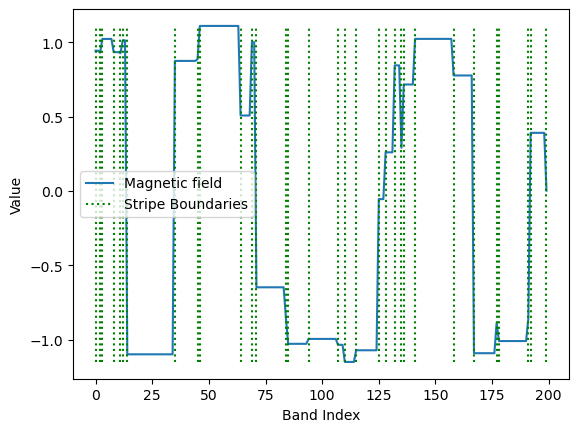

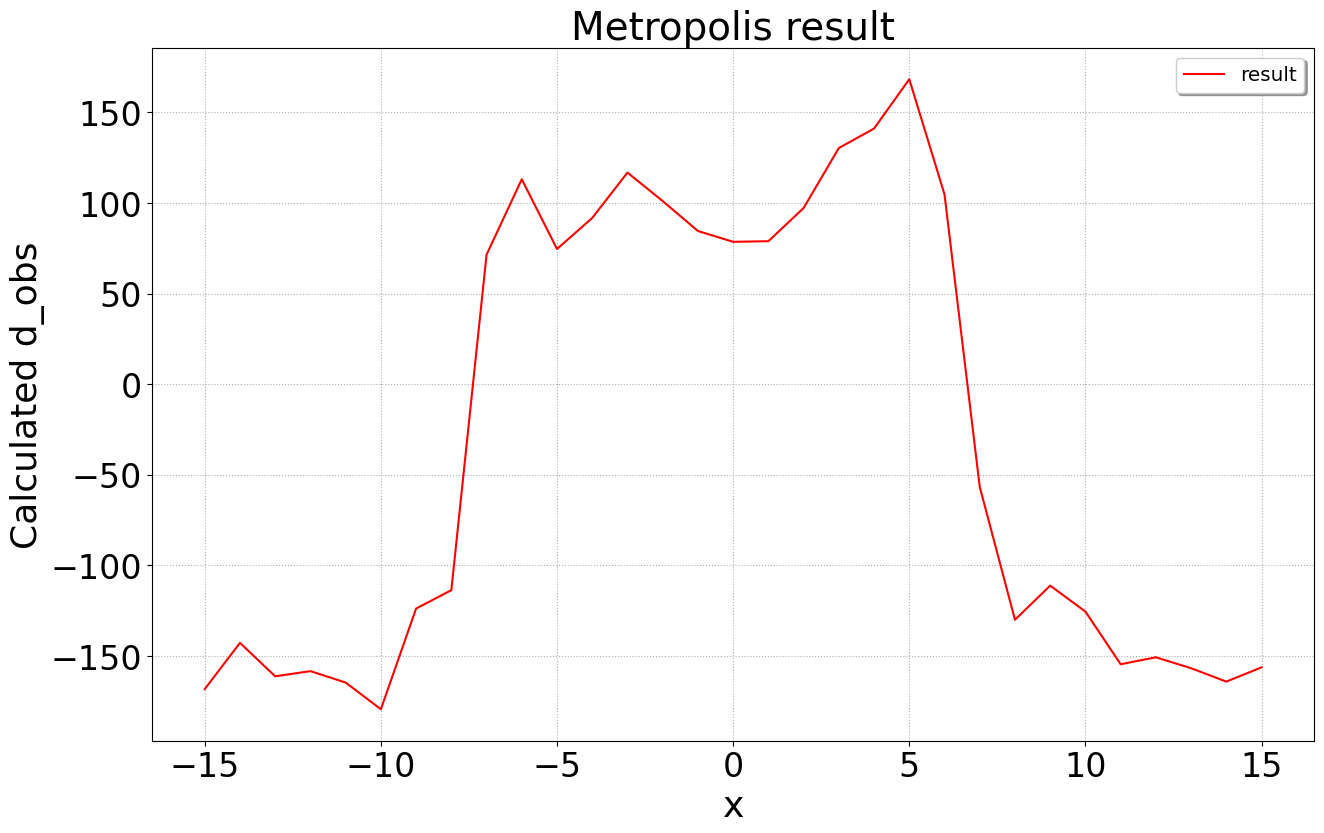

In [12]:
visualize_plate(plate_)
# print(plate_)
plt.show()

# print(np.sum(plate_[:,0]),"hereeee")
plate_ = np.array([plate_[:, 1]])
plate_ = plate_.T
# print(plate_)
x = np.linspace(-15, 15, 31)

# plt.plot(x, g_mat@plate_,"darkcyan",data="g_mat@plate")
# plt.legend()

grafia(x,g_mat@plate_,1,"-","result","r","Metropolis result","x","Calculated d_obs","result.png")
plt.show()
# result123 = gmatrix @ plate[:, 1]
# print(gmatrix)

# question 5

For this section I tried a lot of different methods to obtain the uncertainties and settled for these below. I am not happy with the results I think that with a few tips from the professors I could have done better (my fault because I did not reach out).

I started by calculating the residuals, to see the convergence of the algorithm.

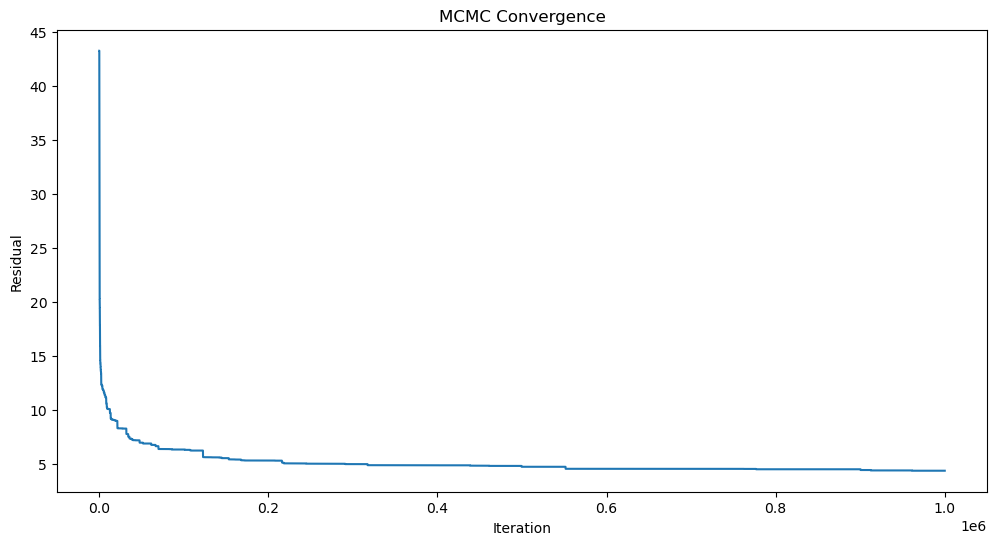

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(residual_list)
plt.xlabel('Iteration')
plt.ylabel('Residual')
plt.title('MCMC Convergence')
plt.savefig('convergence.png')
plt.show()

These are the simple functions used to calculate the uncertainties

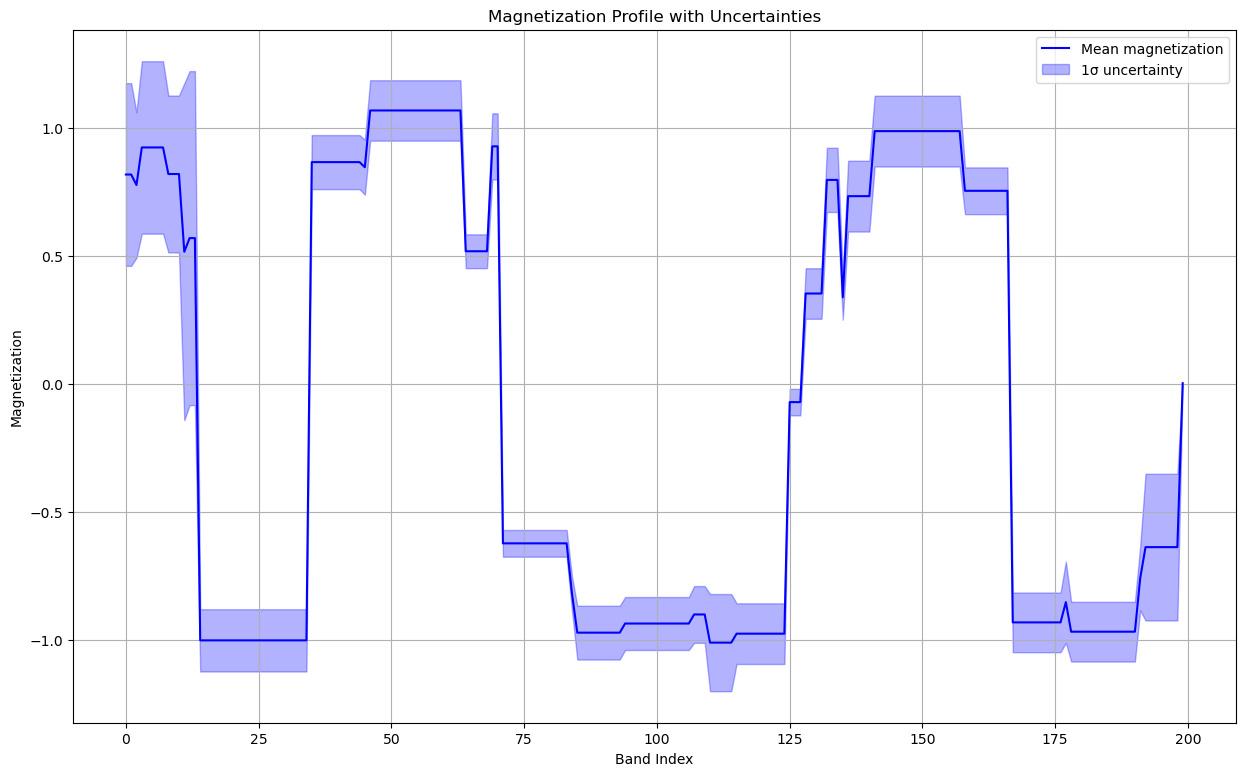

In [14]:
def calculate_uncertainties(samples):
    """
    Calculate mean and uncertainties from MCMC samples
    """
    means = np.mean(samples, axis=0)
    std_devs = np.std(samples, axis=0)
    
    return means, std_devs

def plot_uncertainties(means, std_devs):
    """
    Plot the magnetization profile with uncertainties
    """
    band_indices = np.arange(num_bands)
    
    plt.figure(figsize=(15, 9))
    plt.plot(band_indices, means, 'b-', label='Mean magnetization')
    plt.fill_between(band_indices, 
                     means - std_devs, 
                     means + std_devs, 
                     color='blue', 
                     alpha=0.3, 
                     label='1σ uncertainty')

    
    plt.xlabel('Band Index')
    plt.ylabel('Magnetization')
    plt.title('Magnetization Profile with Uncertainties')
    plt.legend()
    plt.grid(True)
    plt.savefig('magnetization_uncertainties.png')
    plt.show()

means, std_devs = calculate_uncertainties(samples)

# Plot results with uncertainties
plot_uncertainties(means, std_devs)

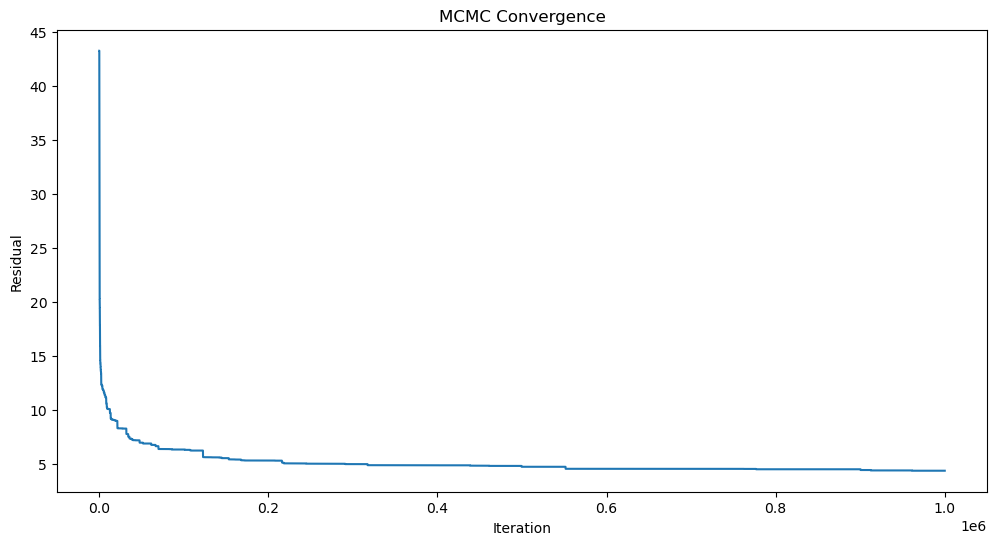


Uncertainty Summary:
Average uncertainty (1σ): 0.137
Maximum uncertainty (1σ): 0.658
Minimum uncertainty (1σ): 0.000


In [15]:
# Calculate and print summary statistics
print("\nUncertainty Summary:")
print(f"Average uncertainty (1σ): {np.mean(std_devs):.3f}")
print(f"Maximum uncertainty (1σ): {np.max(std_devs):.3f}")
print(f"Minimum uncertainty (1σ): {np.min(std_devs):.3f}")
